In [1]:
%matplotlib inline

import os
import time
import datetime
import glob
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scprep
import graphtools as gt
import phate
from scipy import sparse
from scipy.stats import zscore 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import warnings
from adjustText import adjust_text
import sys
sys.path.append('/home/ngr4/project/scripts/')
import utils
import random


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

In [2]:
pdfp = '/home/ngr4/project/sccovid/data/processed'
pfp = '/home/ngr4/project/sccovid/results/'

adata = utils.load_adata(os.path.join(pdfp,'ats.h5ad'))

loaded @200622.16:44:24
took 0.26-s to load data


In [30]:
fname = 'infVbystander'
n_bootstraps = 100

bystander_indices = adata.obs.loc[(adata.obs['Condition']=='SCV2-inoculated') & (adata.obs['scv2_geq1']==0),:].index.to_list()

dge = pd.DataFrame()
for t in range(n_bootstraps):#adata.obs['timepoint'].unique():
    print('\nstarting timepoint {}\n'.format(t))
    start_t=time.time()
    
    cluster='init_ctype'
    groups = ['AT2']#adata.obs[cluster].unique()
    for i in groups :
        start = time.time()
        
        print('  group: {}\n'.format(i))
        
        # random sample of bystander cells
        bystander_indices = adata.obs.loc[(adata.obs['Condition']=='SCV2-inoculated') & (adata.obs['scv2_geq1']==0) & (adata.obs[cluster]==i),:].index.to_list()
        idx = random.sample(bystander_indices, ((adata.obs['Condition']=='SCV2-inoculated') & (adata.obs['scv2_geq1']==1) & (adata.obs[cluster]==i)).sum()) # same size as infected
        
        X = adata[adata.obs.index.isin(idx),:].X.todense()
        X_mut = adata[(adata.obs['Condition']=='SCV2-inoculated') & (adata.obs['scv2_geq1']==1) & (adata.obs[cluster]==i),:].X.todense()
        
        X = np.asarray(X)
        X_mut = np.asarray(X_mut)
        
        print('    Ncells in X:{}'.format(X.shape[0]))
        print('    Ncells in X_mut:{}\n'.format(X_mut.shape[0]))

        p = utils.mwu(X,X_mut,adata.var_names) # directionality doesn't matter
        emd = scprep.stats.differential_expression(X_mut,X,
                                                   measure = 'emd',
                                                   direction='both', 
                                                   gene_names=adata.var_names,
                                                   n_jobs=-1)
        emd['Gene']=emd.index
        emd=emd.drop(columns='rank')
        fc = utils.log2aveFC(X_mut,X,adata.var_names.to_list())
        gene_mismatch = fc['Gene'].isin(p['Gene'])
        if gene_mismatch.any():
            fc = fc.loc[gene_mismatch,:]
            warnings.warn('Warning: {} genes dropped due to p-val NA.'.format((gene_mismatch==False).sum()))
        dt = pd.merge(p,fc,how='left',on="Gene")
        gene_mismatch = emd['Gene'].isin(p['Gene'])
        if gene_mismatch.any():
            emd = emd.loc[gene_mismatch,:]
        dt = pd.merge(dt,emd,how='left',on='Gene')
        dt['Cell type']=[i]*dt.shape[0]
        dt['bootstrap_iter']=[str(t)]*dt.shape[0]
        dt['nlog10pvalcorrected']=(-1)*np.log10(dt['pval_corrected'])
        
        dge = dge.append(dt, ignore_index=True)
        print('... computed in {:.2f}-s'.format(time.time()-start))
    print('\nFinished timepoint {} in {:.2f}-min'.format(t,(time.time()-start_t)/60))
    
if True :
    # save volcano plot data
    dge.to_csv(os.path.join(pfp,'dge_'+fname+'_bootstraps.csv'),index=False)
    dge_min = dge.sort_values('pval').drop_duplicates(['Gene'])
    dge_min.to_csv(os.path.join(pfp,'dge_'+fname+'.csv'),index=False)




starting timepoint 0

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.15-s
... 50% completed in 24.43-s
... 75% completed in 40.02-s

... mwu computed in 58.33-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6909 genes dropped due to p-val NA.


... computed in 61.03-s

Finished timepoint 0 in 1.02-min

starting timepoint 1

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.87-s
... 50% completed in 23.92-s
... 75% completed in 39.35-s

... mwu computed in 57.49-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7085 genes dropped due to p-val NA.


... computed in 59.16-s

Finished timepoint 1 in 0.99-min

starting timepoint 2

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.11-s
... 50% completed in 24.44-s
... 75% completed in 40.03-s

... mwu computed in 58.35-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7031 genes dropped due to p-val NA.


... computed in 60.00-s

Finished timepoint 2 in 1.00-min

starting timepoint 3

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.11-s
... 50% completed in 24.41-s
... 75% completed in 39.99-s

... mwu computed in 58.42-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6924 genes dropped due to p-val NA.


... computed in 60.02-s

Finished timepoint 3 in 1.00-min

starting timepoint 4

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.83-s
... 50% completed in 23.83-s
... 75% completed in 39.09-s

... mwu computed in 57.03-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7256 genes dropped due to p-val NA.


... computed in 58.73-s

Finished timepoint 4 in 0.98-min

starting timepoint 5

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.91-s
... 50% completed in 24.02-s
... 75% completed in 39.33-s

... mwu computed in 57.37-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6650 genes dropped due to p-val NA.


... computed in 58.99-s

Finished timepoint 5 in 0.98-min

starting timepoint 6

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.19-s
... 50% completed in 24.46-s
... 75% completed in 40.02-s

... mwu computed in 58.36-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7108 genes dropped due to p-val NA.


... computed in 59.99-s

Finished timepoint 6 in 1.00-min

starting timepoint 7

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.14-s
... 50% completed in 24.49-s
... 75% completed in 40.12-s

... mwu computed in 58.48-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6997 genes dropped due to p-val NA.


... computed in 60.15-s

Finished timepoint 7 in 1.00-min

starting timepoint 8

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.90-s
... 50% completed in 23.97-s
... 75% completed in 39.25-s

... mwu computed in 57.20-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6786 genes dropped due to p-val NA.


... computed in 58.87-s

Finished timepoint 8 in 0.98-min

starting timepoint 9

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.06-s
... 50% completed in 24.38-s
... 75% completed in 39.96-s

... mwu computed in 58.30-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7217 genes dropped due to p-val NA.


... computed in 59.94-s

Finished timepoint 9 in 1.00-min

starting timepoint 10

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.11-s
... 50% completed in 24.42-s
... 75% completed in 39.98-s

... mwu computed in 58.22-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7487 genes dropped due to p-val NA.


... computed in 59.94-s

Finished timepoint 10 in 1.00-min

starting timepoint 11

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.13-s
... 50% completed in 24.45-s
... 75% completed in 40.01-s

... mwu computed in 58.36-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6309 genes dropped due to p-val NA.


... computed in 60.07-s

Finished timepoint 11 in 1.00-min

starting timepoint 12

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.84-s
... 50% completed in 23.84-s
... 75% completed in 39.07-s

... mwu computed in 56.90-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7451 genes dropped due to p-val NA.


... computed in 58.51-s

Finished timepoint 12 in 0.98-min

starting timepoint 13

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.87-s
... 50% completed in 23.90-s
... 75% completed in 39.21-s

... mwu computed in 57.23-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6934 genes dropped due to p-val NA.


... computed in 58.96-s

Finished timepoint 13 in 0.98-min

starting timepoint 14

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.16-s
... 50% completed in 24.50-s
... 75% completed in 40.16-s

... mwu computed in 58.58-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6750 genes dropped due to p-val NA.


... computed in 60.25-s

Finished timepoint 14 in 1.00-min

starting timepoint 15

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.17-s
... 50% completed in 24.53-s
... 75% completed in 40.20-s

... mwu computed in 58.63-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6508 genes dropped due to p-val NA.


... computed in 60.35-s

Finished timepoint 15 in 1.01-min

starting timepoint 16

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.09-s
... 50% completed in 24.36-s
... 75% completed in 40.02-s

... mwu computed in 58.37-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7565 genes dropped due to p-val NA.


... computed in 60.00-s

Finished timepoint 16 in 1.00-min

starting timepoint 17

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.12-s
... 50% completed in 24.42-s
... 75% completed in 39.99-s

... mwu computed in 58.37-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7342 genes dropped due to p-val NA.


... computed in 60.08-s

Finished timepoint 17 in 1.00-min

starting timepoint 18

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.11-s
... 50% completed in 24.46-s
... 75% completed in 40.10-s

... mwu computed in 58.46-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6781 genes dropped due to p-val NA.


... computed in 60.18-s

Finished timepoint 18 in 1.00-min

starting timepoint 19

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.87-s
... 50% completed in 23.94-s
... 75% completed in 39.34-s

... mwu computed in 57.40-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7076 genes dropped due to p-val NA.


... computed in 59.04-s

Finished timepoint 19 in 0.98-min

starting timepoint 20

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.91-s
... 50% completed in 23.96-s
... 75% completed in 39.24-s

... mwu computed in 57.16-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6920 genes dropped due to p-val NA.


... computed in 58.89-s

Finished timepoint 20 in 0.98-min

starting timepoint 21

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.98-s
... 50% completed in 24.05-s
... 75% completed in 39.38-s

... mwu computed in 57.48-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6935 genes dropped due to p-val NA.


... computed in 59.17-s

Finished timepoint 21 in 0.99-min

starting timepoint 22

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.06-s
... 50% completed in 24.33-s
... 75% completed in 39.91-s

... mwu computed in 58.19-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7031 genes dropped due to p-val NA.


... computed in 59.94-s

Finished timepoint 22 in 1.00-min

starting timepoint 23

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.12-s
... 50% completed in 24.47-s
... 75% completed in 40.12-s

... mwu computed in 58.63-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6764 genes dropped due to p-val NA.


... computed in 60.30-s

Finished timepoint 23 in 1.01-min

starting timepoint 24

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.12-s
... 50% completed in 24.41-s
... 75% completed in 39.99-s

... mwu computed in 58.31-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6988 genes dropped due to p-val NA.


... computed in 60.08-s

Finished timepoint 24 in 1.00-min

starting timepoint 25

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.12-s
... 50% completed in 24.44-s
... 75% completed in 40.02-s

... mwu computed in 58.44-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7133 genes dropped due to p-val NA.


... computed in 60.15-s

Finished timepoint 25 in 1.00-min

starting timepoint 26

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.11-s
... 50% completed in 24.46-s
... 75% completed in 40.10-s

... mwu computed in 58.44-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6982 genes dropped due to p-val NA.


... computed in 60.09-s

Finished timepoint 26 in 1.00-min

starting timepoint 27

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.89-s
... 50% completed in 24.18-s
... 75% completed in 39.76-s

... mwu computed in 58.20-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6786 genes dropped due to p-val NA.


... computed in 59.97-s

Finished timepoint 27 in 1.00-min

starting timepoint 28

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.10-s
... 50% completed in 24.38-s
... 75% completed in 40.10-s

... mwu computed in 58.43-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7039 genes dropped due to p-val NA.


... computed in 60.19-s

Finished timepoint 28 in 1.00-min

starting timepoint 29

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.85-s
... 50% completed in 23.90-s
... 75% completed in 39.23-s

... mwu computed in 57.55-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7031 genes dropped due to p-val NA.


... computed in 59.31-s

Finished timepoint 29 in 0.99-min

starting timepoint 30

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.06-s
... 50% completed in 24.34-s
... 75% completed in 39.89-s

... mwu computed in 58.21-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6891 genes dropped due to p-val NA.


... computed in 59.82-s

Finished timepoint 30 in 1.00-min

starting timepoint 31

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.83-s
... 50% completed in 23.87-s
... 75% completed in 39.13-s

... mwu computed in 57.17-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7151 genes dropped due to p-val NA.


... computed in 58.91-s

Finished timepoint 31 in 0.98-min

starting timepoint 32

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.93-s
... 50% completed in 24.04-s
... 75% completed in 39.42-s

... mwu computed in 57.46-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6731 genes dropped due to p-val NA.


... computed in 59.25-s

Finished timepoint 32 in 0.99-min

starting timepoint 33

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.90-s
... 50% completed in 23.99-s
... 75% completed in 39.35-s

... mwu computed in 57.36-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6892 genes dropped due to p-val NA.


... computed in 59.04-s

Finished timepoint 33 in 0.98-min

starting timepoint 34

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.90-s
... 50% completed in 23.97-s
... 75% completed in 39.32-s

... mwu computed in 57.35-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6847 genes dropped due to p-val NA.


... computed in 59.11-s

Finished timepoint 34 in 0.99-min

starting timepoint 35

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.89-s
... 50% completed in 23.92-s
... 75% completed in 39.23-s

... mwu computed in 57.24-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6701 genes dropped due to p-val NA.


... computed in 58.99-s

Finished timepoint 35 in 0.98-min

starting timepoint 36

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.07-s
... 50% completed in 24.47-s
... 75% completed in 40.06-s

... mwu computed in 58.34-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6945 genes dropped due to p-val NA.


... computed in 60.00-s

Finished timepoint 36 in 1.00-min

starting timepoint 37

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.88-s
... 50% completed in 23.97-s
... 75% completed in 39.28-s

... mwu computed in 57.31-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6698 genes dropped due to p-val NA.


... computed in 59.07-s

Finished timepoint 37 in 0.98-min

starting timepoint 38

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.88-s
... 50% completed in 24.03-s
... 75% completed in 39.54-s

... mwu computed in 57.62-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6496 genes dropped due to p-val NA.


... computed in 59.41-s

Finished timepoint 38 in 0.99-min

starting timepoint 39

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.94-s
... 50% completed in 24.02-s
... 75% completed in 39.36-s

... mwu computed in 57.42-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6700 genes dropped due to p-val NA.


... computed in 59.13-s

Finished timepoint 39 in 0.99-min

starting timepoint 40

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.93-s
... 50% completed in 24.03-s
... 75% completed in 39.34-s

... mwu computed in 57.30-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6722 genes dropped due to p-val NA.


... computed in 59.10-s

Finished timepoint 40 in 0.99-min

starting timepoint 41

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.91-s
... 50% completed in 24.06-s
... 75% completed in 39.52-s

... mwu computed in 57.49-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6660 genes dropped due to p-val NA.


... computed in 59.26-s

Finished timepoint 41 in 0.99-min

starting timepoint 42

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.16-s
... 50% completed in 24.60-s
... 75% completed in 40.28-s

... mwu computed in 58.66-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6659 genes dropped due to p-val NA.


... computed in 60.44-s

Finished timepoint 42 in 1.01-min

starting timepoint 43

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.11-s
... 50% completed in 24.44-s
... 75% completed in 40.06-s

... mwu computed in 58.49-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6560 genes dropped due to p-val NA.


... computed in 60.21-s

Finished timepoint 43 in 1.00-min

starting timepoint 44

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.05-s
... 50% completed in 24.31-s
... 75% completed in 39.87-s

... mwu computed in 58.20-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7578 genes dropped due to p-val NA.


... computed in 59.99-s

Finished timepoint 44 in 1.00-min

starting timepoint 45

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.11-s
... 50% completed in 24.42-s
... 75% completed in 39.97-s

... mwu computed in 58.30-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7009 genes dropped due to p-val NA.


... computed in 60.14-s

Finished timepoint 45 in 1.00-min

starting timepoint 46

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.13-s
... 50% completed in 24.28-s
... 75% completed in 39.60-s

... mwu computed in 57.59-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6760 genes dropped due to p-val NA.


... computed in 59.34-s

Finished timepoint 46 in 0.99-min

starting timepoint 47

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.14-s
... 50% completed in 24.49-s
... 75% completed in 40.12-s

... mwu computed in 58.45-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6776 genes dropped due to p-val NA.


... computed in 60.26-s

Finished timepoint 47 in 1.00-min

starting timepoint 48

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.91-s
... 50% completed in 24.04-s
... 75% completed in 39.55-s

... mwu computed in 57.72-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6266 genes dropped due to p-val NA.


... computed in 59.51-s

Finished timepoint 48 in 0.99-min

starting timepoint 49

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.84-s
... 50% completed in 23.83-s
... 75% completed in 39.04-s

... mwu computed in 56.98-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6965 genes dropped due to p-val NA.


... computed in 58.80-s

Finished timepoint 49 in 0.98-min

starting timepoint 50

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.82-s
... 50% completed in 23.79-s
... 75% completed in 39.02-s

... mwu computed in 56.93-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7481 genes dropped due to p-val NA.


... computed in 58.65-s

Finished timepoint 50 in 0.98-min

starting timepoint 51

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.14-s
... 50% completed in 24.53-s
... 75% completed in 40.10-s

... mwu computed in 58.47-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6480 genes dropped due to p-val NA.


... computed in 60.27-s

Finished timepoint 51 in 1.00-min

starting timepoint 52

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.95-s
... 50% completed in 24.10-s
... 75% completed in 39.46-s

... mwu computed in 57.56-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6562 genes dropped due to p-val NA.


... computed in 59.37-s

Finished timepoint 52 in 0.99-min

starting timepoint 53

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.86-s
... 50% completed in 23.93-s
... 75% completed in 39.26-s

... mwu computed in 57.28-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6870 genes dropped due to p-val NA.


... computed in 59.02-s

Finished timepoint 53 in 0.98-min

starting timepoint 54

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.11-s
... 50% completed in 24.46-s
... 75% completed in 40.11-s

... mwu computed in 58.50-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7085 genes dropped due to p-val NA.


... computed in 60.35-s

Finished timepoint 54 in 1.01-min

starting timepoint 55

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.83-s
... 50% completed in 23.84-s
... 75% completed in 39.11-s

... mwu computed in 57.00-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7533 genes dropped due to p-val NA.


... computed in 58.82-s

Finished timepoint 55 in 0.98-min

starting timepoint 56

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.17-s
... 50% completed in 24.54-s
... 75% completed in 40.15-s

... mwu computed in 58.51-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6909 genes dropped due to p-val NA.


... computed in 60.36-s

Finished timepoint 56 in 1.01-min

starting timepoint 57

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.12-s
... 50% completed in 24.43-s
... 75% completed in 40.03-s

... mwu computed in 58.39-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6810 genes dropped due to p-val NA.


... computed in 60.14-s

Finished timepoint 57 in 1.00-min

starting timepoint 58

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.92-s
... 50% completed in 24.04-s
... 75% completed in 39.56-s

... mwu computed in 57.69-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6938 genes dropped due to p-val NA.


... computed in 59.53-s

Finished timepoint 58 in 0.99-min

starting timepoint 59

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.84-s
... 50% completed in 23.90-s
... 75% completed in 39.23-s

... mwu computed in 57.18-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7261 genes dropped due to p-val NA.


... computed in 58.98-s

Finished timepoint 59 in 0.98-min

starting timepoint 60

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.00-s
... 50% completed in 24.06-s
... 75% completed in 39.45-s

... mwu computed in 57.48-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6785 genes dropped due to p-val NA.


... computed in 59.24-s

Finished timepoint 60 in 0.99-min

starting timepoint 61

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.11-s
... 50% completed in 24.37-s
... 75% completed in 39.91-s

... mwu computed in 58.21-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7496 genes dropped due to p-val NA.


... computed in 60.06-s

Finished timepoint 61 in 1.00-min

starting timepoint 62

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.90-s
... 50% completed in 23.99-s
... 75% completed in 39.35-s

... mwu computed in 57.38-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6627 genes dropped due to p-val NA.


... computed in 59.20-s

Finished timepoint 62 in 0.99-min

starting timepoint 63

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.12-s
... 50% completed in 24.48-s
... 75% completed in 40.13-s

... mwu computed in 58.47-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6941 genes dropped due to p-val NA.


... computed in 60.22-s

Finished timepoint 63 in 1.00-min

starting timepoint 64

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.14-s
... 50% completed in 24.51-s
... 75% completed in 40.20-s

... mwu computed in 58.62-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6808 genes dropped due to p-val NA.


... computed in 60.44-s

Finished timepoint 64 in 1.01-min

starting timepoint 65

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.83-s
... 50% completed in 23.84-s
... 75% completed in 39.13-s

... mwu computed in 57.12-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7132 genes dropped due to p-val NA.


... computed in 58.98-s

Finished timepoint 65 in 0.98-min

starting timepoint 66

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.20-s
... 50% completed in 24.63-s
... 75% completed in 40.30-s

... mwu computed in 58.70-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6627 genes dropped due to p-val NA.


... computed in 60.47-s

Finished timepoint 66 in 1.01-min

starting timepoint 67

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.87-s
... 50% completed in 23.88-s
... 75% completed in 39.20-s

... mwu computed in 57.27-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6884 genes dropped due to p-val NA.


... computed in 59.17-s

Finished timepoint 67 in 0.99-min

starting timepoint 68

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.08-s
... 50% completed in 24.41-s
... 75% completed in 39.99-s

... mwu computed in 58.25-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6961 genes dropped due to p-val NA.


... computed in 60.13-s

Finished timepoint 68 in 1.00-min

starting timepoint 69

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.91-s
... 50% completed in 24.03-s
... 75% completed in 39.41-s

... mwu computed in 57.43-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6531 genes dropped due to p-val NA.


... computed in 59.19-s

Finished timepoint 69 in 0.99-min

starting timepoint 70

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.88-s
... 50% completed in 23.96-s
... 75% completed in 39.30-s

... mwu computed in 57.33-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6929 genes dropped due to p-val NA.


... computed in 59.16-s

Finished timepoint 70 in 0.99-min

starting timepoint 71

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.14-s
... 50% completed in 24.44-s
... 75% completed in 40.03-s

... mwu computed in 58.40-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6838 genes dropped due to p-val NA.


... computed in 60.25-s

Finished timepoint 71 in 1.00-min

starting timepoint 72

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.93-s
... 50% completed in 24.10-s
... 75% completed in 39.71-s

... mwu computed in 57.86-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6454 genes dropped due to p-val NA.


... computed in 59.73-s

Finished timepoint 72 in 1.00-min

starting timepoint 73

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.93-s
... 50% completed in 23.98-s
... 75% completed in 39.30-s

... mwu computed in 57.34-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6519 genes dropped due to p-val NA.


... computed in 59.15-s

Finished timepoint 73 in 0.99-min

starting timepoint 74

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.16-s
... 50% completed in 24.50-s
... 75% completed in 40.12-s

... mwu computed in 58.49-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6532 genes dropped due to p-val NA.


... computed in 60.34-s

Finished timepoint 74 in 1.01-min

starting timepoint 75

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.85-s
... 50% completed in 23.91-s
... 75% completed in 39.24-s

... mwu computed in 57.27-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7407 genes dropped due to p-val NA.


... computed in 59.14-s

Finished timepoint 75 in 0.99-min

starting timepoint 76

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.89-s
... 50% completed in 23.95-s
... 75% completed in 39.31-s

... mwu computed in 57.34-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6906 genes dropped due to p-val NA.


... computed in 59.11-s

Finished timepoint 76 in 0.99-min

starting timepoint 77

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.94-s
... 50% completed in 24.03-s
... 75% completed in 39.40-s

... mwu computed in 57.35-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6779 genes dropped due to p-val NA.


... computed in 59.24-s

Finished timepoint 77 in 0.99-min

starting timepoint 78

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.17-s
... 50% completed in 24.57-s
... 75% completed in 40.26-s

... mwu computed in 58.71-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6338 genes dropped due to p-val NA.


... computed in 60.61-s

Finished timepoint 78 in 1.01-min

starting timepoint 79

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.18-s
... 50% completed in 24.59-s
... 75% completed in 40.29-s

... mwu computed in 58.77-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6274 genes dropped due to p-val NA.


... computed in 60.67-s

Finished timepoint 79 in 1.01-min

starting timepoint 80

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.11-s
... 50% completed in 24.46-s
... 75% completed in 40.05-s

... mwu computed in 58.32-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7193 genes dropped due to p-val NA.


... computed in 60.11-s

Finished timepoint 80 in 1.00-min

starting timepoint 81

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.92-s
... 50% completed in 24.01-s
... 75% completed in 39.44-s

... mwu computed in 57.45-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6800 genes dropped due to p-val NA.


... computed in 59.33-s

Finished timepoint 81 in 0.99-min

starting timepoint 82

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.84-s
... 50% completed in 23.90-s
... 75% completed in 39.19-s

... mwu computed in 57.15-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7177 genes dropped due to p-val NA.


... computed in 58.92-s

Finished timepoint 82 in 0.98-min

starting timepoint 83

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.95-s
... 50% completed in 24.08-s
... 75% completed in 39.44-s

... mwu computed in 57.48-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6799 genes dropped due to p-val NA.


... computed in 59.37-s

Finished timepoint 83 in 0.99-min

starting timepoint 84

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.09-s
... 50% completed in 24.48-s
... 75% completed in 40.26-s

... mwu computed in 58.63-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6611 genes dropped due to p-val NA.


... computed in 60.53-s

Finished timepoint 84 in 1.01-min

starting timepoint 85

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.03-s
... 50% completed in 24.29-s
... 75% completed in 39.89-s

... mwu computed in 58.16-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7515 genes dropped due to p-val NA.


... computed in 60.01-s

Finished timepoint 85 in 1.00-min

starting timepoint 86

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.13-s
... 50% completed in 24.45-s
... 75% completed in 40.02-s

... mwu computed in 58.36-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6617 genes dropped due to p-val NA.


... computed in 60.25-s

Finished timepoint 86 in 1.00-min

starting timepoint 87

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.12-s
... 50% completed in 24.46-s
... 75% completed in 40.14-s

... mwu computed in 58.54-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7088 genes dropped due to p-val NA.


... computed in 60.48-s

Finished timepoint 87 in 1.01-min

starting timepoint 88

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.15-s
... 50% completed in 24.51-s
... 75% completed in 40.12-s

... mwu computed in 58.47-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6950 genes dropped due to p-val NA.


... computed in 60.42-s

Finished timepoint 88 in 1.01-min

starting timepoint 89

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.09-s
... 50% completed in 24.40-s
... 75% completed in 40.02-s

... mwu computed in 58.28-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7191 genes dropped due to p-val NA.


... computed in 60.08-s

Finished timepoint 89 in 1.00-min

starting timepoint 90

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.16-s
... 50% completed in 24.55-s
... 75% completed in 40.26-s

... mwu computed in 58.71-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6584 genes dropped due to p-val NA.


... computed in 60.63-s

Finished timepoint 90 in 1.01-min

starting timepoint 91

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.90-s
... 50% completed in 23.95-s
... 75% completed in 39.26-s

... mwu computed in 57.25-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6688 genes dropped due to p-val NA.


... computed in 59.13-s

Finished timepoint 91 in 0.99-min

starting timepoint 92

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.06-s
... 50% completed in 24.32-s
... 75% completed in 39.88-s

... mwu computed in 58.16-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7126 genes dropped due to p-val NA.


... computed in 60.03-s

Finished timepoint 92 in 1.00-min

starting timepoint 93

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.17-s
... 50% completed in 24.56-s
... 75% completed in 40.22-s

... mwu computed in 58.66-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6492 genes dropped due to p-val NA.


... computed in 60.57-s

Finished timepoint 93 in 1.01-min

starting timepoint 94

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.87-s
... 50% completed in 23.93-s
... 75% completed in 39.21-s

... mwu computed in 57.15-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6922 genes dropped due to p-val NA.


... computed in 58.97-s

Finished timepoint 94 in 0.98-min

starting timepoint 95

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.13-s
... 50% completed in 24.46-s
... 75% completed in 40.11-s

... mwu computed in 58.56-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6675 genes dropped due to p-val NA.


... computed in 60.51-s

Finished timepoint 95 in 1.01-min

starting timepoint 96

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.17-s
... 50% completed in 24.54-s
... 75% completed in 40.26-s

... mwu computed in 58.71-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6442 genes dropped due to p-val NA.


... computed in 60.63-s

Finished timepoint 96 in 1.01-min

starting timepoint 97

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.17-s
... 50% completed in 24.59-s
... 75% completed in 40.40-s

... mwu computed in 58.83-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6322 genes dropped due to p-val NA.


... computed in 60.67-s

Finished timepoint 97 in 1.01-min

starting timepoint 98

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 11.14-s
... 50% completed in 24.51-s
... 75% completed in 40.15-s

... mwu computed in 58.56-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 6458 genes dropped due to p-val NA.


... computed in 60.49-s

Finished timepoint 98 in 1.01-min

starting timepoint 99

  group: AT2

    Ncells in X:38
    Ncells in X_mut:38

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 10.88-s
... 50% completed in 23.94-s
... 75% completed in 39.25-s

... mwu computed in 57.31-s



/home/ngr4/project/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:344: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: 7226 genes dropped due to p-val NA.


... computed in 59.24-s

Finished timepoint 99 in 0.99-min


# Volcano 

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


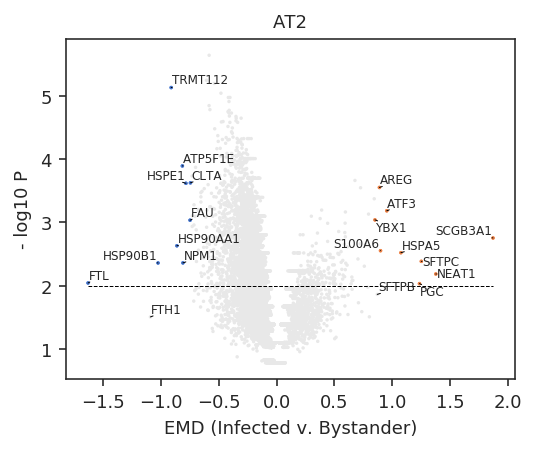

In [74]:
# filter the dge a bit
ctype = 'AT2'

# take pval uncorrected

if True:
    # load
    dge = pd.read_csv(os.path.join(pfp,'dge_'+fname+'.csv'))

# just work with plot of interest
dt = dge.loc[dge['Cell type']==ctype,['Gene','emd', 'pval', 'log2FC']]
dt['nlog10pval'] = -1*np.log10(dt['pval'])

# drop scv2 transcript 
dt = dt.loc[dt['Gene']!='scv2_orf1-10',:]

if True:
    # drop mito, ribosomal, and MALAT1 genes
    genes2exclude = [g for g in dt['Gene'] if 'MT-' in g or g.startswith('RPS') or g.startswith('RPL')] + ['MALAT1']
    dt = dt.loc[(~dt['Gene'].isin(genes2exclude)), :]


# get max pval of non-infinite ones and re-assign to inf ones
dt.loc[dt['nlog10pval'].isin([-np.inf, np.inf]), 'nlog10pval'] = np.ceil(dt.loc[~dt['nlog10pval'].isin([-np.inf, np.inf]), 'nlog10pval'].max())

# just label top 10 and bottom 10
dt = dt.sort_values(by='emd') # sort by EMD
dt = dt.reset_index()
top10 = dt['Gene'][0:10].to_list()
bottom10 = dt['Gene'][-10:].to_list()

# just label top 10 and bottom 10
dt = dt.sort_values(by='emd') # sort by EMD
dt = dt.reset_index()
top10 = dt['Gene'][0:10].to_list()
bottom10 = dt['Gene'][-10:].to_list()
    
genes_volcano = {fname:top10+bottom10}


    
## aesthetics
cmap_volcano={'N.S.':'#E8E8E866','Up':sns.color_palette('muted')[1],
              'Down':sns.color_palette('muted')[0],'B.H. cutoff':'#E8E8E8'}
dt['Significance']=['N.S.']*dt.shape[0]
dt['Significance'][(dt['pval']<=0.01)]='B.H. cutoff'
dt['Significance'][((dt['pval']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano[fname] else False for i in dt['Gene']]))]='Up'
dt['Significance'][((dt['pval']<=0.01) & (dt['log2FC']<0) & ([True if i in genes_volcano[fname] else False for i in dt['Gene']]))]='Down'

## plot
fig,ax=plt.subplots(1,1,figsize=(4,3))
p2=sns.scatterplot(x='emd',y='nlog10pval',
                  data=dt.loc[((dt['Significance']!='Up') | (dt['Significance']!='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
p2top=sns.scatterplot(x='emd',y='nlog10pval',
                  data=dt.loc[((dt['Significance']=='Up') | (dt['Significance']=='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
ax.plot([dt['emd'].min(),dt['emd'].max()],
        (-1)*np.log10([0.01,0.01]),
        'k--',lw=0.5) # BH cut off
ax.set(xlabel='EMD (Infected v. Bystander)',ylabel='- log10 P', title=ctype)



idx_g={}
for g in genes_volcano[fname]: # match fname with dict key
    idx_g[g]=[i for i,v in enumerate(dt['Gene']) if v==g][0] # assumes unique namees

texts = [ax.text(dt['emd'][i],dt['nlog10pval'][i],g,fontsize=6) for g,i in idx_g.items()]
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'volcano_{}_{}.pdf'.format(fname,ctype)),dpi=300, bbox_inches='tight')




In [76]:
adata.obs['Infected'] = adata.obs['scv2_geq1'].map({1:'Infected', 0:'Bystander'})
adata.obs.loc[adata.obs['Condition']=='Mock', 'Infected'] = 'Mock'
adata.obs['Infected'] = adata.obs['Infected'].astype('category')

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


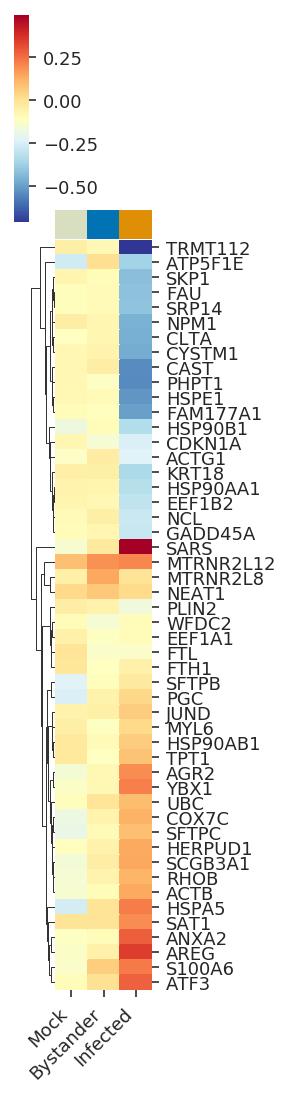

In [94]:
# HEATMAP
cmap_infected = {'Mock':sns.cubehelix_palette(4, start=.5, rot=-.75)[0],
                 'Bystander':sns.color_palette('colorblind')[0],
                 'Infected':sns.color_palette('colorblind')[1]}

# grab top25 up and down (assume dt sorted)
n = 25
topn = dt['Gene'][0:n].to_list()
bottomn = dt['Gene'][-n:].to_list()
    
genes_heatmap = {fname:topn+bottomn}

# construct dataframe
X = pd.DataFrame(np.asarray(adata[:,genes_heatmap[fname]].X.todense()), 
                columns=genes_heatmap[fname])
X['Cell type'] = adata.obs['init_ctype'].astype(str).to_list()
X['Infected'] = adata.obs['Infected'].astype(str).to_list()

x = X
x.loc[:,genes_heatmap[fname]] = zscore(x.loc[:,genes_heatmap[fname]]) # over whole dataset
x = X.loc[X['Cell type']==ctype,:]


x['Infected'] = x['Infected'].astype('category')

ave_zscore = x.groupby(['Infected']).mean().T
order = ['Mock', 'Bystander', 'Infected']
ave_zscore = ave_zscore[order]
p = sns.clustermap(
    ave_zscore,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=None,
    figsize=(2,8),
    cbar_kws=None,
    row_cluster=True,
    col_cluster=False,
    row_linkage=None,
    col_linkage=None,
    row_colors=None,
    col_colors=list(map(cmap_infected.get, order)),
    mask=None,
    cmap='RdYlBu_r',
    yticklabels=True,
#     vmin=-2,vmax=2,
)
p.ax_heatmap.set_xlabel('')
p.ax_heatmap.set_xticklabels(order, rotation=45, ha='right')

if True:
    p.savefig(os.path.join(pfp,'heatmap_top25updown_{}_{}.png'.format(fname,ctype)),dpi=300,bbox_inches='tight')